# Stroke Prediction Dataset

### Integrantes

• Christopher Sebastian, Charaf Herrera 

• Cecilia Azul, Villanueva

• Niels Pacheco

[Link del dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Los accidentes cerebrovasculares son una preocupación significativa de salud a nivel mundial, a menudo conllevan consecuencias graves, como discapacidades a largo plazo o la muerte. Predecir la probabilidad de un accidente cerebrovascular puede desempeñar un papel crucial en la intervención y el tratamiento temprano, lo que potencialmente podría salvar vidas y mejorar los resultados para los pacientes.

En este notebook, analizaremos un conjunto de datos que contiene diversas características de los pacientes para predecir la ocurrencia de accidentes cerebrovasculares. Exploraremos diferentes modelos de aprendizaje automático, evaluaremos su rendimiento y determinaremos el enfoque más efectivo para la predicción de accidentes cerebrovasculares.

In [2]:
#IMPORTS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import lazypredict
#from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report,mean_squared_error

---

## Análisis Exploratorio de datos

Cargamos el dataset

In [3]:
df = pd.read_csv(".\healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


---

## Valores nulos y outliers

Revisamos el numero exacto de nulos en la columna bmi

Del analisis anterior, no es beneficioso reemplazar los valores nulos de bmi por la media debido a los outliers, asi que reemplazaremos por la mediana

In [4]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

Validamos el cambio

Dropeamos ID ya que no es relevante

In [5]:
df = df.drop("id",axis=1)

Usamos binary encoding para ever_married

In [6]:
df['ever_married'].value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [7]:
df['ever_married'] = df['ever_married'].map({'Yes':1 ,'No':0})

In [8]:
df['ever_married'].value_counts()

ever_married
1    3353
0    1757
Name: count, dtype: int64

Gender tiene 1 valor diferente que es Other, por lo que lo eliminaremos

In [9]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [10]:
df = df[df['gender'] != 'Other']

In [11]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Ahora solo tenemos 2 valores en Gender

---

## Feature engineering

Mas del 95% de los datos son de la clase 0, por lo que es un dataset desbalanceado, lo que puede afectar el rendimiento del modelo

### One-hot encoding

In [12]:
df = pd.get_dummies(df).astype(int)
df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,1,228,36,1,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61,0,0,1,202,28,1,1,0,0,0,0,1,0,1,0,0,0,1,0
2,80,0,1,1,105,32,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49,0,0,1,171,34,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,79,1,0,1,174,24,1,1,0,0,0,0,1,0,1,0,0,0,1,0


### Upsampling

In [13]:
# Utilizaremos SMOTE (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
# SMOTE significa Técnica de Sobremuestreo de Minorías Sintéticas.
# Es una técnica utilizada en aprendizaje automático para abordar conjuntos de datos desequilibrados.
# Identificación del Desequilibrio: comenzamos reconociendo que el conjunto de datos tiene una clase minoritaria, como casos de enfermedades raras en un conjunto de datos médicos, o en este caso la tasa de ACVs.
from imblearn.over_sampling import SMOTE

In [14]:
x = df.drop("stroke",axis=1)
y = df.stroke

In [15]:
x.shape , y.shape , y.value_counts()

((5109, 19),
 (5109,),
 stroke
 0    4860
 1     249
 Name: count, dtype: int64)

In [16]:
smote = SMOTE(sampling_strategy="minority")

In [17]:
#fiteamos
x_smote , y_smote = smote.fit_resample(x,y)                

In [18]:
# ahora tenemos el mismo numero de datos para ambas clases
y_smote.value_counts()


stroke
1    4860
0    4860
Name: count, dtype: int64

---

## Predicciones


In [19]:
#separamos en train y test
x_train , x_test , y_train , y_test = train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)

In [20]:
#escalamos los datos
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Redes Neuronales

Probemos el desempeño de una red neuronal de 2 capas, usando ReLu y una funcion de activacion sigmoidea, utilizaremos BCELoss como funcion de pérdida ya que estamos ante un problema de clasificacion binaria

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# definimos el modelo de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Definimos los hiperparámetros
input_size = x_train.shape[1] # Number of features
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 1000

# creamos el modelo
model = NeuralNetwork(input_size, hidden_size, output_size)

# funcion de perdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# tensores
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# entrenamiento
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # backpropagation y optimizacion
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # mostrar el progreso de perdida y accuracy cada 10 epochs
    if (epoch+1) % 10 == 0:
        outputs = (outputs >= 0.5).float()
        accuracy = accuracy_score(y_train_tensor, outputs)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/1000], Loss: 0.6818, Accuracy: 0.5837
Epoch [20/1000], Loss: 0.6290, Accuracy: 0.8086
Epoch [30/1000], Loss: 0.5802, Accuracy: 0.8745
Epoch [40/1000], Loss: 0.5317, Accuracy: 0.8970
Epoch [50/1000], Loss: 0.4826, Accuracy: 0.9061
Epoch [60/1000], Loss: 0.4335, Accuracy: 0.9119
Epoch [70/1000], Loss: 0.3864, Accuracy: 0.9218
Epoch [80/1000], Loss: 0.3433, Accuracy: 0.9307
Epoch [90/1000], Loss: 0.3055, Accuracy: 0.9342
Epoch [100/1000], Loss: 0.2734, Accuracy: 0.9370
Epoch [110/1000], Loss: 0.2469, Accuracy: 0.9398
Epoch [120/1000], Loss: 0.2250, Accuracy: 0.9448
Epoch [130/1000], Loss: 0.2071, Accuracy: 0.9478
Epoch [140/1000], Loss: 0.1924, Accuracy: 0.9488
Epoch [150/1000], Loss: 0.1803, Accuracy: 0.9513
Epoch [160/1000], Loss: 0.1703, Accuracy: 0.9513
Epoch [170/1000], Loss: 0.1620, Accuracy: 0.9523
Epoch [180/1000], Loss: 0.1550, Accuracy: 0.9549
Epoch [190/1000], Loss: 0.1492, Accuracy: 0.9551
Epoch [200/1000], Loss: 0.1442, Accuracy: 0.9555
Epoch [210/1000], Loss: 0.140

Exportar modelo a archivo json

In [ ]:
import json
# Guardar el modelo en formato JSON
def save_model_to_json(model, file_path):
    model_dict = {
        "architecture": {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
        },
        "state_dict": {k: v.tolist() for k, v in model.state_dict().items()}
    }
    with open(file_path, "w") as json_file:
        json.dump(model_dict, json_file)
    print(f"Modelo guardado en {file_path}")

save_model_to_json(model, "rnn_model.json")

Modelo guardado en trained_model.json


Exportamos los datasets truncando los digitos decimales para evitar problemas con los hashes

In [ ]:
ds_xtrain=pd.DataFrame(x_train)
ds_xtest=pd.DataFrame(x_test)

ds_xtrain.columns = x.columns
ds_xtest.columns = x.columns

# Aplicar la transformación para limitar a 110 decimales
stroke_data_test=ds_xtest.applymap(lambda x: f"{x:.10f}" if isinstance(x, (int, float)) else x)

stroke_data_train=ds_xtrain.applymap(lambda x: f"{x:.10f}" if isinstance(x, (int, float)) else x)


stroke_data_train.to_csv('stroke_data_train.csv',index=False)
stroke_data_test.to_csv('stroke_data.csv',index=False)

In [32]:
# Evaluacion en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(ds_xtest.values, dtype=torch.float32))
    test_outputs = (test_outputs >= 0.5).float()

test_outputs = test_outputs.numpy().flatten()
test_outputs

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Test Accuracy: 0.9604


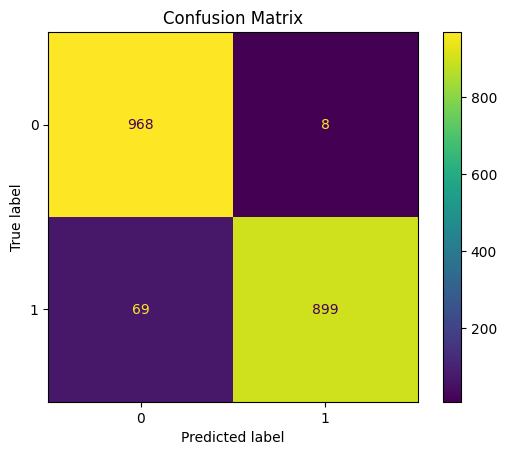

In [36]:
# Evaluacion en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(x_test_tensor)

test_outputs = (test_outputs >= 0.5).float()

test_outputs = test_outputs.numpy().flatten()
test_accuracy = accuracy_score(y_test_tensor, test_outputs)
print(f'Test Accuracy: {test_accuracy:.4f}')

    # Confusion Matrix
cm = confusion_matrix(y_test_tensor, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Classification Report
report = classification_report(y_test_tensor, test_outputs)
print('Métricas para redes neuronales:')
print(report)

# Calculamos las métricas de evaluación
accuracy = accuracy_score(y_test_tensor, test_outputs)
precision = precision_score(y_test_tensor,test_outputs, average='binary')  # usamos binary porque es un problema de clasificación binaria
recall = recall_score(y_test_tensor,test_outputs, average='binary')
f1 = f1_score(y_test_tensor, test_outputs, average='binary')
mse = mean_squared_error(y_test_tensor, test_outputs)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Métricas para redes neuronales:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       976
         1.0       0.99      0.93      0.96       968

    accuracy                           0.96      1944
   macro avg       0.96      0.96      0.96      1944
weighted avg       0.96      0.96      0.96      1944

Accuracy: 0.96
Precision: 0.99
Recall: 0.93
F1 Score: 0.96
Mean Squared Error: 0.04
